# Annual temperature anomalies relative to the pre-industrial period

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

from statsmodels.nonparametric.smoothers_lowess import lowess

## EDA


### Reading the Data and creating Time Series


In [2]:
db = pd.read_csv("temperature-anomaly.csv")
db = db[["Year","Global average temperature anomaly relative to 1861-1890","Lower bound of the annual temperature anomaly (95% confidence interval)","Upper bound of the annual temperature anomaly (95% confidence interval)"]]
db = db.rename(columns={
    "Global average temperature anomaly relative to 1861-1890" : "Anomaly",
    "Lower bound of the annual temperature anomaly (95% confidence interval)" : "Lower Bound",
    "Upper bound of the annual temperature anomaly (95% confidence interval)" : "Upper Bound"
})
print(db.head())

   Year   Anomaly  Lower Bound  Upper Bound
0  1850 -0.055414    -0.226959     0.116131
1  1851  0.128948    -0.049570     0.307466
2  1852  0.132899    -0.047085     0.312882
3  1853  0.091943    -0.067712     0.251598
4  1854  0.070777    -0.070414     0.211968


In [3]:
dates = pd.date_range(start='1850', periods=len(db), freq='YE')
mytimeseries = pd.DataFrame(db.iloc[:, 1:].values, index=dates, columns=db.columns[1:])

print("\nTime series info:")
print(mytimeseries.info())
print(mytimeseries.head())


Time series info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 1850-12-31 to 2025-12-31
Freq: YE-DEC
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Anomaly      176 non-null    float64
 1   Lower Bound  176 non-null    float64
 2   Upper Bound  176 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None
             Anomaly  Lower Bound  Upper Bound
1850-12-31 -0.055414    -0.226959     0.116131
1851-12-31  0.128948    -0.049570     0.307466
1852-12-31  0.132899    -0.047085     0.312882
1853-12-31  0.091943    -0.067712     0.251598
1854-12-31  0.070777    -0.070414     0.211968


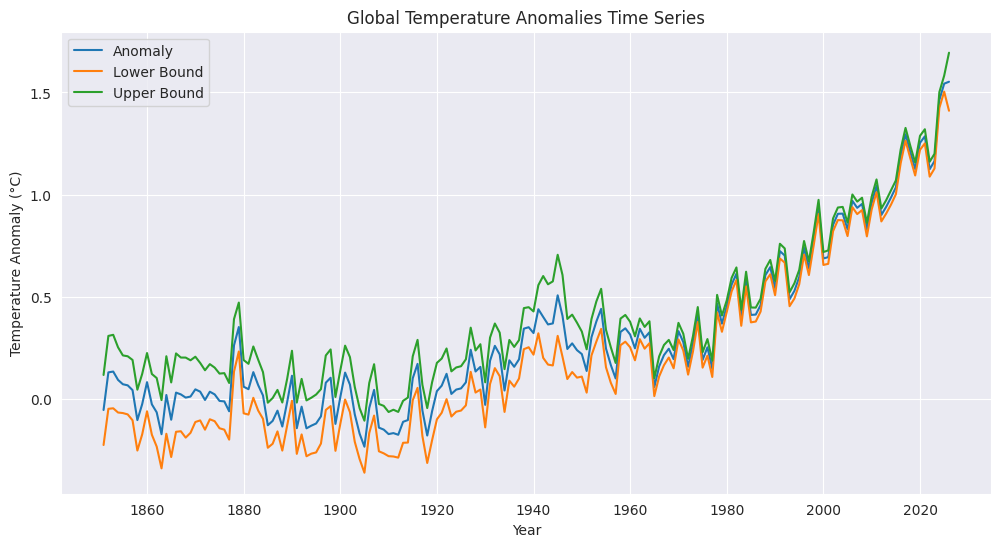

In [4]:
plt.figure(figsize=(12, 6))
for col in mytimeseries.columns:
    plt.plot(mytimeseries.index, mytimeseries[col], label=col)

plt.title("Global Temperature Anomalies Time Series")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

For this analysis, the primary focus is on the global average temperature anomaly. While the dataset provides upper and lower bounds to indicate uncertainty, these values are not essential for understanding the overall trend. The average anomaly alone captures how much the Earth's surface temperature has deviated from pre-industrial levels each year.

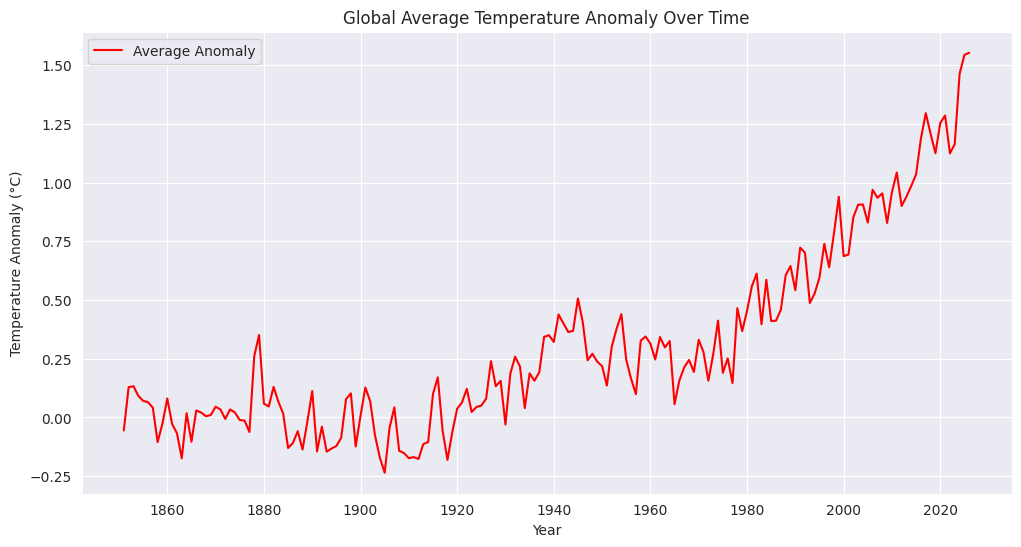

In [5]:
average_anomaly = mytimeseries['Anomaly']


plt.figure(figsize=(12, 6))
plt.plot(average_anomaly.index, average_anomaly, color='red', label='Average Anomaly')
plt.title("Global Average Temperature Anomaly Over Time")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.legend()
plt.show()

By concentrating on the average, we can clearly observe the long-term warming trend without the distraction of additional columns. This simplification makes the analysis cleaner, easier to interpret, and directly highlights the magnitude of global temperature changes over time.

### Descriptive Analysis of the Time Series

The series shows a clear upward trend over the past 170+ years, indicating a gradual increase in global temperatures relative to
   pre-industrial levels.

Although there is a general warming trend, the anomalies fluctuate from year to year, with some years being cooler or warmer than the previous year.

The early 20th century shows relatively small deviations, while the late 20th and early 21st centuries exhibit larger positive anomalies, with record highs in recent decades.

The warming trend is gradual over decades, rather than abrupt jumps, although occasional short-term dips are visible due to natural variability.


## Time Series Components

In this section, we analyze the main components of the dataset before applying a formal time series decomposition.

#### 1. Trend
The series shows a **clear upward trend** in global temperature anomalies.
The trend is not perfectly linear: warming is modest before the mid-20th century and accelerates strongly in recent decades.

#### 2. Seasonality

Since the data is **annual** and aggregated at the **global level**, no intra-year seasonal pattern can be observed.
- Hemispheric seasons cancel each other out (summer in one hemisphere corresponds to winter in the other).
- Furthermore, the anomaly calculation is performed relative to a baseline climatology, which already removes the average seasonal cycle.

As a result, this dataset only reflects **long-term trend** and **year-to-year variability**, but not seasonal fluctuations.


#### 3. Variance and Heteroscedasticity
Some evidence of heteroscedasticity is present. In earlier decades (late 19th and early 20th century), the spread of anomalies appears wider. Over time, the range between upper and lower fluctuations narrows.

This narrowing is largely due to **improvements in scientific measurement and global coverage** rather than a real change in climate variability. As more weather stations, ocean buoys, and later satellites were incorporated, the estimates of global temperature anomalies became more precise, reducing uncertainty.

Thus, while the variance of the series shows modest changes, these are best interpreted as **data quality effects** rather than fundamental changes in climate dynamics.

#### 4. Additive vs Multiplicative Structure
Despite small changes in variance, the dataset is best represented by an **additive model**:


$$y_t=T_t + R_t$$


- The **trend** captures the long-term warming signal.
- The **noise** represents short-term variability .
- A multiplicative model is not appropriate, since fluctuations do not scale with the level of the series.



## Time Series Decomposition

In this section we separate the series into its core parts to understand what drives the behavior: a smooth trend (long-run warming) and a remainder (short-run fluctuations). Annual data have no within-year seasonality, so a seasonal component is not modeled.

#### Method (additive, annual)

#### 1. Smoothing for Trend
- **LOWESS:** a locally weighted smoother that traces the central path while ignoring year-to-year noise.
- **10-year centered rolling mean:** an assumption-light average of a 10-year window (≈ 5 years before + 5 years after each year).

#### 2. Remainder
We define the remainder as the observed anomaly minus the smooth trend:
$$
\mathrm{Remainder}_t \;=\; \mathrm{Anomaly}_t \;-\; \widehat{\mathrm{Trend}}_t
$$

We analyze the remainder to check **serial correlation** (persistence) and **variance changes** (heteroscedasticity).

#### 3. Uncertainty
We visualize the **95% confidence band** (*Lower Bound* / *Upper Bound*) around the anomaly to communicate **estimation uncertainty**.


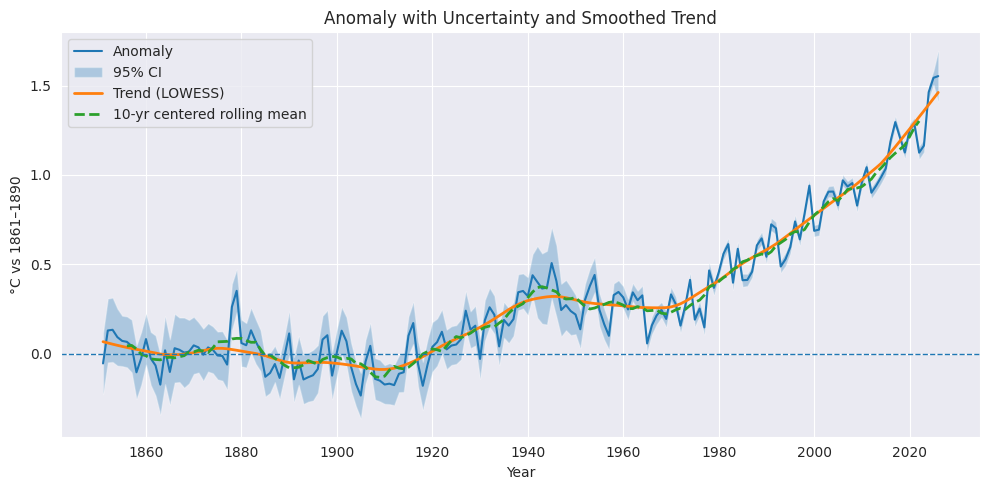

In [9]:
ts = mytimeseries[['Anomaly','Lower Bound','Upper Bound']].sort_index()
x      = np.arange(len(ts))                            
years  = ts.index.to_pydatetime()                         
an     = ts['Anomaly'].to_numpy(dtype=float)
lo_ci  = ts['Lower Bound'].to_numpy(dtype=float)
hi_ci  = ts['Upper Bound'].to_numpy(dtype=float)


low = lowess(an, x, frac=0.15, return_sorted=False)      
roll = ts['Anomaly'].rolling(10, center=True).mean().to_numpy()
remainder = an - low

plt.figure(figsize=(10,5))
plt.plot(years, an, label='Anomaly')
plt.fill_between(years, lo_ci, hi_ci, alpha=0.3, label='95% CI')
plt.plot(years, low, linewidth=2, label='Trend (LOWESS)')
plt.plot(years, roll, linewidth=2, linestyle='--', label='10-yr centered rolling mean')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Anomaly with Uncertainty and Smoothed Trend')
plt.xlabel('Year'); plt.ylabel('°C vs 1861–1890'); plt.legend()
plt.tight_layout(); plt.show()

Both smoothers (LOWESS and the 10-year mean) tell the same story: a persistent long-run warming. Early decades hover near the baseline; the curve bends upward in the 20th century and rises more sharply in recent decades, which is consistent with acceleration of warming.

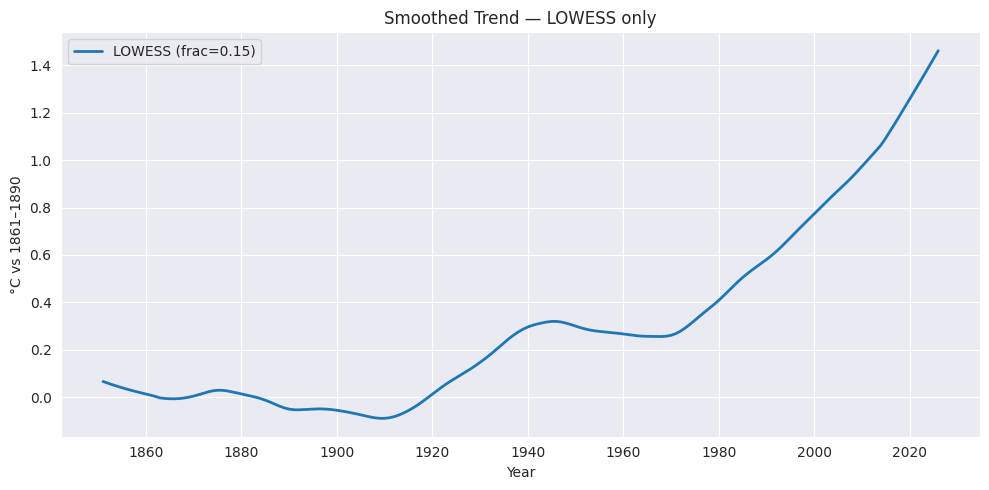

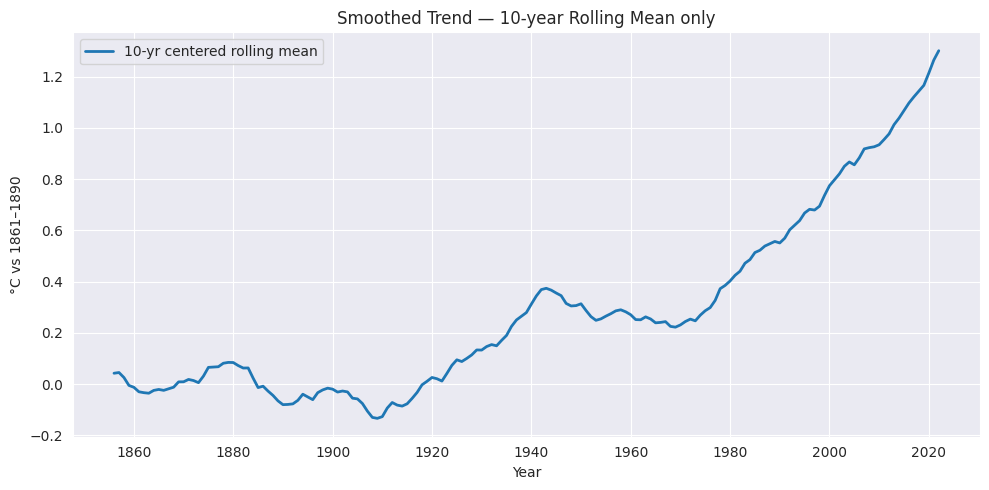

In [10]:

plt.figure(figsize=(10,5))
plt.plot(years, low, linewidth=2, label="LOWESS (frac=0.15)")
plt.title("Smoothed Trend — LOWESS only")
plt.xlabel("Year"); plt.ylabel("°C vs 1861–1890")
plt.legend(); plt.tight_layout()
plt.show()

# ----- 10-year centered rolling mean only -----
plt.figure(figsize=(10,5))
plt.plot(years, roll, linewidth=2, label="10-yr centered rolling mean")
plt.title("Smoothed Trend — 10-year Rolling Mean only")
plt.xlabel("Year"); plt.ylabel("°C vs 1861–1890")
plt.legend(); plt.tight_layout()
plt.show()

#### **Why two smoothers?**

- LOWESS is flexible and can reveal gentle changes in slope without choosing a hard breakpoint.

- The 10-year mean is transparent and robust: if both agree, the result isn’t an artifact of one method.

#### **Remainder**

We observed the remainder to look for the following:
- Is it centered around 0 (no lingering trend)?
- Is the variance roughly stable or does it change over time?
- Is there serial correlation (do changes cluster from year to year)?


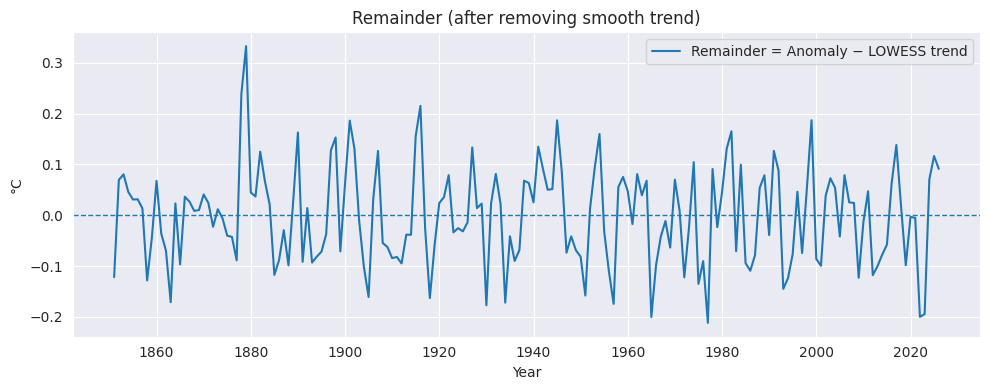

In [8]:
plt.figure(figsize=(10,4))
plt.plot(years, remainder, label='Remainder = Anomaly − LOWESS trend')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('Remainder (after removing smooth trend)')
plt.xlabel('Year'); plt.ylabel('°C'); plt.legend()
plt.tight_layout(); plt.show()


After extracting a smooth trend, the remainder is approximately mean-zero, indicating the trend captures the long-run warming. The remainder exhibits brief runs and a few spikes, consistent with short-run variability. Year-to-year changes (first differences) fluctuate around zero but occur in bursts, suggesting short-run persistence rather than pure white noise. The amplitude of deviations is generally modest (≈ ±0.1 °C, with occasional ±0.2–0.3 °C), and the spread appears to vary somewhat across periods, hinting at heteroscedasticity.

### **First differences (ΔAnomaly)**

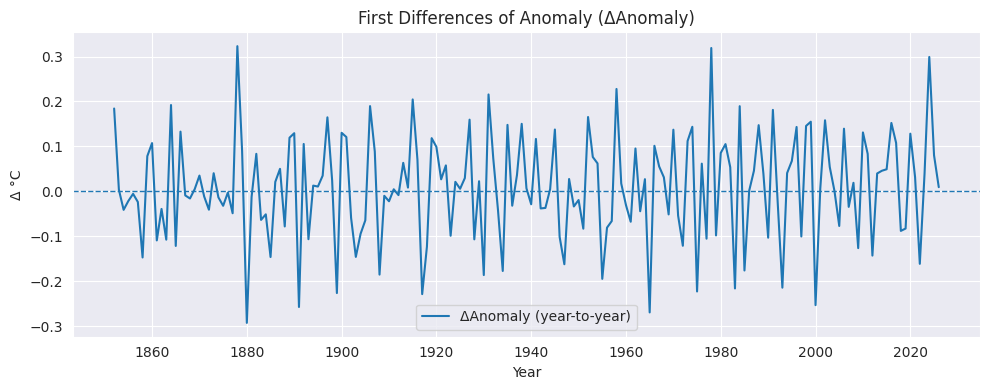

In [11]:
diff = ts['Anomaly'].diff().dropna()

plt.figure(figsize=(10,4))
plt.plot(diff.index.to_pydatetime(), diff.values, label='ΔAnomaly (year-to-year)')
plt.axhline(0, linestyle='--', linewidth=1)
plt.title('First Differences of Anomaly (ΔAnomaly)')
plt.xlabel('Year'); plt.ylabel('Δ °C'); plt.legend()
plt.tight_layout(); plt.show()


- **Centered at zero:** Year-to-year changes bounce around 0 → no leftover trend in the differences.
- **Bursts of larger moves:** Periods with consecutive positive or negative changes indicate **persistence** (changes aren’t purely random).
- **Magnitude:** Typical fluctuations are small (a few hundredths of a degree), with occasional years showing jumps near **±0.2–0.3 °C**.

**Conclusion:** ΔAnomaly shows **non-random clustering** of annual changes, suggesting some **serial dependence** in the short run (common in climate time series).


### **Lag Plots**

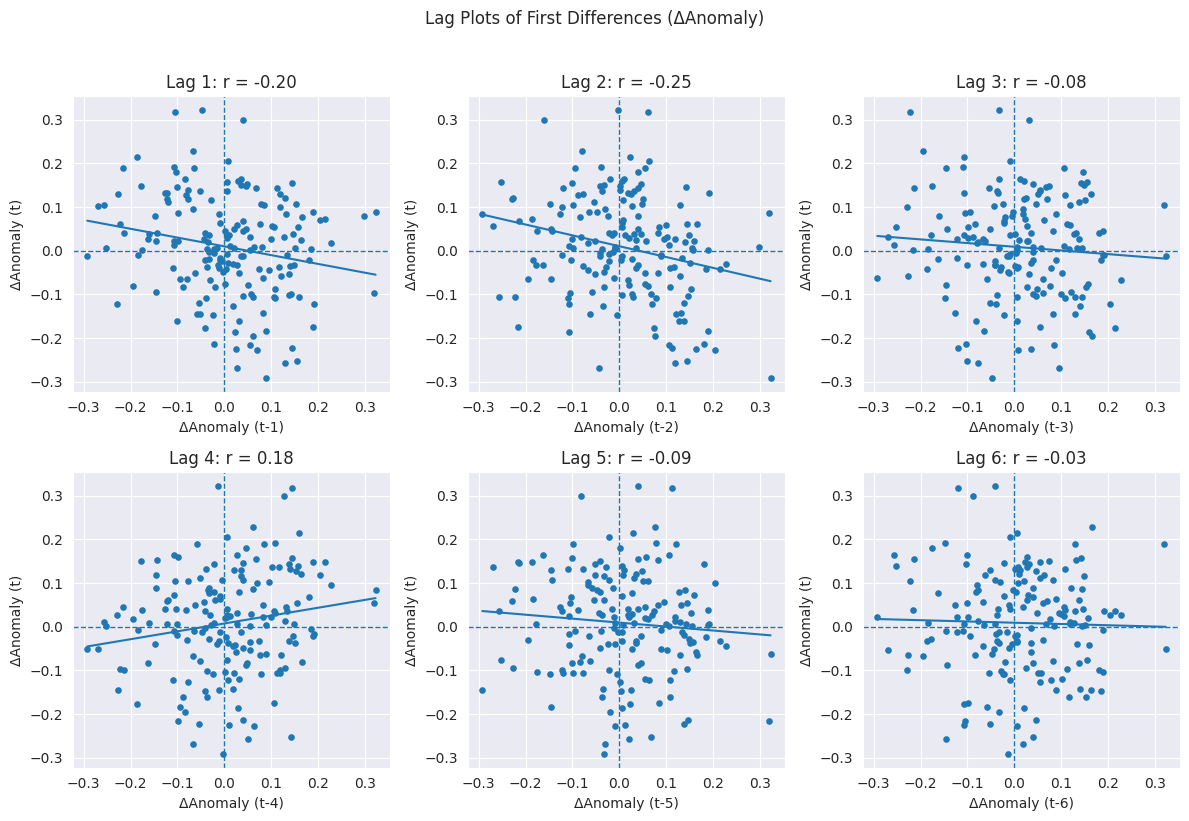

Pearson r by lag: {'lag_1': -0.20242107039942142, 'lag_2': -0.24948057726702533, 'lag_3': -0.08333213991502406, 'lag_4': 0.1778966113139705, 'lag_5': -0.08885165224733683, 'lag_6': -0.02844961771451604}


In [12]:
diff = ts["Anomaly"].diff().dropna()

lags = [1, 2, 3, 4, 5, 6]

n = len(lags)
rows = int(np.ceil(n/3))
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)

for ax, k in zip(axes.ravel(), lags):
    x = diff.shift(k).dropna()
    y = diff.loc[x.index]

    ax.scatter(x.values, y.values, s=14)
    if len(x) > 1:
        m, b = np.polyfit(x.values, y.values, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, m*xs + b)

    r = np.corrcoef(x.values, y.values)[0, 1]
    ax.set_title(f"Lag {k}: r = {r:.2f}")
    ax.set_xlabel(f"ΔAnomaly (t-{k})")
    ax.set_ylabel("ΔAnomaly (t)")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.axvline(0, linestyle="--", linewidth=1)

for j in range(n, rows*cols):
    fig.delaxes(axes.ravel()[j])

fig.suptitle("Lag Plots of First Differences (ΔAnomaly)", y=1.02)
fig.tight_layout()
plt.show()

corrs = {f"lag_{k}": float(np.corrcoef(diff.shift(k).dropna().values,
                                       diff.loc[diff.shift(k).dropna().index].values)[0,1])
         for k in lags}
print("Pearson r by lag:", corrs)


Lag plots of year-to-year changes (ΔAnomaly) show negative correlation at lags 1–2 (r ≈ −0.20 to −0.25), indicating partial mean-reversion in consecutive years. Correlations at higher lags are close to zero, with a small positive blip at lag 4 (r ≈ +0.18). Overall, serial dependence is short-lived and modest.

### What the lag-plot results mean for temperatures

- **Year-to-year “rate-of-change” tends to bounce back a bit.**  
  Because ΔAnomaly at lags 1–2 is **negative**, a year with a bigger-than-usual **increase** is often followed by a year with a **smaller increase or a slight dip** (and vice versa). That’s **partial mean-reversion** in the changes.

- **But the long-term level still goes up.**  
  This mean-reversion is **short-lived and modest**, so it **does not cancel** the long-run warming. 

- **Limited memory = limited short-term predictability.**  
  Since correlations fade after **1–2 years** and are small in size, temperatures don’t “remember” much beyond the very recent past. Short-term ups/downs are **noisy**, so we don’t expect strong multi-year predictability from these simple lags alone.

- **A tiny 4-year echo (weak).**  
  The small **positive** bump at lag 4 hints that every ~4 years there can be a mild tendency for changes to line up in the same direction, but it’s **weak**—could be chance or a faint imprint of multi-year climate variability (e.g., ocean–atmosphere patterns). **Not a headline.**


## **Conclusion**

This project analyzed **annual global temperature anomalies** using a simple **Trend + Remainder** framework, supported by a few targeted diagnostics.

- **Long-run trend.** A smooth trend (LOWESS or a 10-year centered mean) shows a **clear, persistent warming** across the record, with a visibly **steeper rise in recent decades**. A straight-line fit summarizes the pace of change in a single number (°C per century), confirming a sustained upward trajectory.

- **Uncertainty (95% band behavior).** The shaded 95% band is **wider in earlier decades** and **narrower in recent decades**, consistent with improved coverage and measurement. Importantly, in the modern period the **entire band sits mostly above 0**, indicating that, even when having the uncertainty in consideration, recent years are **warmer than the baseline**.

- **Remainder (after removing the trend).** The remainder oscillates around **zero**, indicating the trend captures the main structure. It shows **brief runs and occasional spikes**—the normal, short-run variability you expect from climate and measurement noise—without undermining the long-term rise.

- **Serial correlation (short-run dependence).** Lag plots of **year-to-year changes (ΔAnomaly)** reveal **modest, short-lived serial dependence** (noticeable at the first couple of lags). This means big changes can “carry over” briefly, but the memory fades quickly; it offers **limited short-term predictability**.



### Bottom line
The evidence points to a **robust, long-term warming** signal with **short-run wiggles** that are modest and transient. While year-to-year changes can cluster briefly and variability shifts across eras, none of these features overturns the central result: the global temperature anomaly has **trended upward** and remains **elevated relative to the historical baseline**.

